# JudoBot (JB): A Reinforcement Learning Agent For Basic Judo Mechanics
## (I suck at Judo so I trained a computer to do it for me)
*by MaryLena Bleile*

I have trained a reinforcement learning agent to play Judo using a basic simulated environment. The environment mechanics include gripping, stance, stamina, and win conditions between a "Tori" (self) and an "Uke" (opponent). It does not currently differentiate between specific throws (e.g. Seioi Nage, Tai otoshi), but broadly categorizes throws as North-South (NS, typically resulting in a fall to the back) and East-West (EW, resulting in a fall to the side). 


North-South throws could look like this:


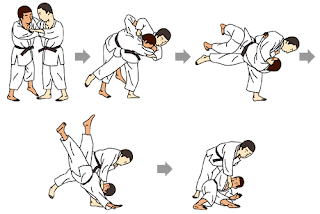



East-West throws could look like this:

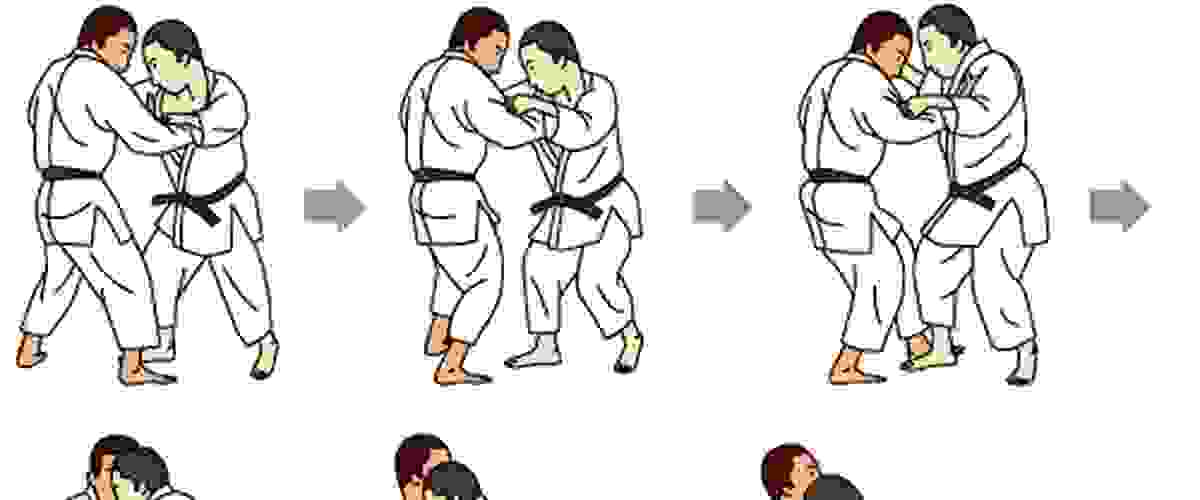

**Bonus** 

Me doing a front throw on a spanish national heavyweight champ :)

(Please copy and paste link into a new tab: Clicking directly may throw error)

[https://marylenableile.com/img/VID_120030528_232102_149.mp4](https://)

## Library imports

In [ ]:
import numpy as np
import pandas as pd
import itertools
from functools import reduce
import operator
import os
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# global variables

## Environment class


The JudoBot simulation environment is a stylized, discrete-time model of tactical interactions in Judo. Each state encodes a configuration of grip control, stance, fatigue, and game status for both the agent (Tori) and its opponent (Uke). The state space is defined as a Cartesian product of the following variables:

 - **Self grip** (left, right): {0, 1}

- **Opponent grip** (left, right): {0, 1}

- **Self stance**: {right, square, left}

- **Opponent stance**: {right, square, left}

 - **Self fatigue**: {0, 1}

- **Opponent fatigue**: {0, 1}

- **Game outcome**: {-1, 0, 1} (loss, ongoing, win)

Each episode begins in a neutral state and proceeds for a maximum of T rounds. During each round, the opponent first takes an action from a fixed or stochastic policy, and then the agent chooses its action. Legal actions include movement, gripping, breaking grips, and executing throws. Fatigue stats (0 or 1) and stamina (0 to 20) are tracked separately from one another: If a player is fatigued, then throw effectiveness is reduced. 

### Main mechanistic functions

**get_valid_actions()**
Some actions can only be attempted in specific states. For example, "breakgripL", corresponding to breaking uke's left grip, is only available if uke has a left grip. Similarly, throws cannot be attempted with no grips. The "get valid action" function retrieves the valid actions that JB can take, while "get valid opp actions" retrieves the valid actions that uke (the opponent) can take.

**giveReward()**
The environment rewards are sparse: +1 for victory, -1 for loss, and 0 otherwise. Loss occurs if uke throws JB or if the episode times out without no throws. giveReward function retrieves the reward status from the state. This function could be elaborated upon if we desired, for example, to give intermediary rewards for successful grips and such.


**_build_throw_success_table()**
Success of JB's throws is determined via a probabilistic lookup table conditioned on stance, fatigue, and grip configuration; this table is constructed once upon environment class initiation using the function _build_throw_success_table(). Starting the function name with an underscore makes it an "internal" function to the object class. 

**apply_opp_action()**
This function modifies the state based on uke's action. For simplicity, uke's throw success is deterministic: if uke has both hands on, throws always succeed. However, uke chooses actions randomly. This loosely represents the case where uke is a true black belt who is choosing to "play down" his/her skills so that JB can learn.  


**nxtPosition()**
This function applies the state transition dynamics. JB moves first, then uke. We first check what valid actions exist in the state using get_valid_actions function, then JB picks what it thinks is the best one out of those values. Next, the opponent's valid actions are found using get_valid_opp_actions, and the action is chosen randomly from that valid action set. The opponent's action is applied using apply_opp_action.

**reset()**
This function resets the environment to default state with no grips and right-foot-forward stance for both players. It will be called in training at the end of each episode (game).

### Helper functions

**visualize_state()**
We visualize what JB is doing by creating an annotated cartoon depiction of each state. This function creates the plot for each specific state and saves it to a directory. At the end, we can knit them all together into a stop-motion animation.

**_qualitative_throw_label()**
This is a helper function for translating numeric probabilities to human-readable labels. For now, JB's throws can have low, medium, or high probability of success. This is another internal function, called only by _build_throw_success_table().

**get_index()**
This function retrieves the state element index from the state name. For example whether or not JB has left grip  ("SelfLeftGrip") is the first element in the state vector, so get_index("SelfLeftGrip") returns the value 0. This function is not completely necessary, but I find it is helpful for making the code more readable.


In [ ]:
##Define environment class
class Env:
    def __init__(self):

        GRIPSL = [0,1]
        GRIPSR = [0,1]
        GRIPOL = [0,1]
        GRIPOR = [0,1]
        #0: right, 1: square, 2: left
        #S: Self, O: Opponent
        STANCES = [0,1,2]
        STANCEO = [0,1,2]
        GAME_WON = [-1,0,1]
        FATIGUES = [0,1]
        FATIGUEO = [0,1]
        
        STATE_ELEMS = [GRIPSL, GRIPSR, GRIPOL, GRIPOR,STANCES, STANCEO, FATIGUES, FATIGUEO, GAME_WON]
        STATE_NAMES = ["SelfLeftGrip", "SelfRightGrip", "OppLeftGrip","OppRightGrip","SelfStance","OppStance","SelfFatigue","OppFatigue","GameWin"]
        self.stateidx = {name: i for i, name in enumerate(STATE_NAMES)}
        #start with no grips or anything
        self.START = np.zeros(len(STATE_NAMES))
        self.STM_DIM = reduce(operator.mul, map(len, STATE_ELEMS))
        self.state          = self.START
        self.step_counter  = 0
        self.agent_stamina  = 20
        self.opp_stamina    = 20
        self.isEnd          = False
        self.max_steps = 10
        self.opp_actions = ["gripL", "gripR", "breakgripL","breakgripR", "mv","throwEW", "throwNS"]
        self._throw_success_table = self._build_throw_success_table()

        # build helpers
        self.stm_key    = pd.DataFrame(list(itertools.product(*STATE_ELEMS)),
                                       columns=STATE_NAMES)
        self._tuple2idx = {tuple(row): i for i, row
                           in enumerate(self.stm_key.values)}

        # Opponent’s random action set  (very small & simple, expand later)
        #self.opp_actions = ["noop", "breakgrip", "gripL", "gripR", "mv"]


    def reset(self):
        self.state          = self.START
        self.step_counter  = 0
        self.agent_stamina  = 20
        self.opp_stamina    = 20
        self.isEnd          = False
        
    def giveReward(self):
        return self.state[self.stateidx["GameWin"]]
        

    def get_index(self, s):
        return self._tuple2idx[tuple(s.astype(int))]

    def get_valid_actions(self, actions_list):
        valid = ["mv"]
        stance = self.state[self.stateidx["SelfStance"]]
        L_grip = self.state[self.stateidx["SelfLeftGrip"]]
        R_grip = self.state[self.stateidx["SelfRightGrip"]]
        O_Lgrip = self.state[self.stateidx["OppLeftGrip"]]
        O_Rgrip = self.state[self.stateidx["OppRightGrip"]]
        any_grip = (L_grip == 1 or R_grip == 1)
    
        if any_grip:
            valid.append("throwNS")
            valid.append("throwEW")
        if O_Lgrip==1:
            valid.append("breakgripL")
        if O_Rgrip==1:
            valid.append("breakgripR")
        if L_grip ==0:
            valid.append("gripL")
        if R_grip == 0:
            valid.append("gripR")
        return valid
        
    def _qualitative_throw_label(self, stance, f_self, f_opp, grips):
        both_grip = grips == "Both"
        any_grip  = grips in ["Left", "Right", "Both"]

        def label(t):
            if both_grip or (f_opp and not f_self):
                return "High"
            if f_opp or not f_self:
                if t == "throwNS" and stance == 1 and any_grip:
                    return "Medium"
                if t == "throwEW" and stance == 0 and grips == "Right":
                    return "Medium"
            return "Low"
        return {t: label(t) for t in ["throwNS", "throwEW"]}

    def _build_throw_success_table(self):

        stances = [0, 1, 2]                  # right, square, left
        fatigue = [0, 1]                     # 0 = fresh, 1 = fatigued
        grips   = ["None", "Left", "Right", "Both"]
        throws  = ["throwNS", "throwEW"]

        prob_map = {"Low": 0.1, "Medium": 0.5, "High": 0.9}

        table = {}
        for st in stances:
            for f_self in fatigue:
                for f_opp in fatigue:
                    for g in grips:
                        labels = self._qualitative_throw_label(st, f_self, f_opp, g)
                        for t in throws:
                            key = (st, f_self, f_opp, g, t)
                            table[key] = prob_map[labels[t]]
        return table
        
    def get_valid_opp_actions(self, actions_list):
        valid = ["mv"]
        stance = self.state[self.stateidx["OppStance"]]
        L_grip = self.state[self.stateidx["OppLeftGrip"]]
        R_grip = self.state[self.stateidx["OppRightGrip"]]
        Tori_Lgrip = self.state[self.stateidx["SelfLeftGrip"]]
        Tori_Rgrip = self.state[self.stateidx["SelfRightGrip"]]
        any_grip = (L_grip == 1 or R_grip == 1)
    
        if any_grip:
            valid.append("throwNS")
            valid.append("throwEW")
        if Tori_Lgrip==1:
            valid.append("breakgripL")
        if Tori_Rgrip==1:
            valid.append("breakgripR")
        if L_grip ==0:
            valid.append("gripL")
        if R_grip == 0:
            valid.append("gripR")
            
            
        return valid


    def apply_opp_action(self, action):
        state = self.state.copy()
    
        if action == "mv":
            state[self.stateidx["OppStance"]] = (state[self.stateidx["OppStance"]] + 1) % 3
    
        elif action == "gripL":
            state[self.stateidx["OppLeftGrip"]] = 1
    
        elif action == "gripR":
            state[self.stateidx["OppRightGrip"]] = 1
    
        elif action == "breakgripL":
            state[self.stateidx["SelfLeftGrip"]] = 0
    
        elif action == "breakgripR":
            state[self.stateidx["SelfRightGrip"]] = 0
    
        elif "throw" in action:
            # Implement opponent throw logic 
            stance = state[self.stateidx["OppStance"]]
            L_grip = state[self.stateidx["OppLeftGrip"]] ==1
            R_grip = state[self.stateidx["OppRightGrip"]] ==1
            T_Lgrip = state[self.stateidx["SelfLeftGrip"]] == 1
            T_Rgrip = state[self.stateidx["SelfRightGrip"]] == 1
    
            any_grip = (L_grip or R_grip)
            both_grip = (L_grip and R_grip)
            T_no_grip = (not T_Rgrip ) and (not T_Lgrip)
            throwsuccess = False
    
            if both_grip or ((state[self.stateidx["OppFatigue"]] == 0) and (state[self.stateidx["SelfFatigue"]]==1)):
                throwsuccess = True
            elif state[self.stateidx["OppFatigue"]] == 0 or (state[self.stateidx["SelfFatigue"]]==1):
                    if stance == 1 and any_grip and action == "throwNS":
                        throwsuccess = True
                    elif stance == 0 and (state[self.stateidx["OppRightGrip"]] == 1) and (( state[self.stateidx["SelfLeftGrip"]]  == 0) or (state[self.stateidx["SelfRightGrip"]] == 0)):
                        throwsuccess = True
                
            
    
            if throwsuccess:
                state[self.stateidx["GameWin"]] = -1  # opponent wins = agent loses
            else:
                self.opp_stamina -= 4
    
        self.opp_stamina -= 0.5
        if self.opp_stamina < 15:
                state[self.stateidx["OppFatigue"]] = 1
        self.state = state

    

    def nxtPosition(self, action, return_index=False, visualize=False, step=None):
        
            

         # If uke has just won, stop here
        if self.isEnd:                        # (note: self.isEnd, not self.isEND)
            if return_index:
                return self.get_index(self.state)
            return self.state.copy()
        else:
            s = self.state.copy()       # local alias
    
            # Gripping
            has_left  = s[self.stateidx["SelfLeftGrip"]]  == 1
            has_right = s[self.stateidx["SelfRightGrip"]] == 1
            stance = s[self.stateidx["SelfStance"]]
            any_grip  = has_left or has_right
            both_grip = has_left and has_right
            if action == "gripL":  s[self.stateidx["SelfLeftGrip"]]  = 1
            elif action == "gripR":  s[self.stateidx["SelfRightGrip"]] = 1
            elif action == "breakgripL":  # break *uke* grips
                s[self.stateidx["OppLeftGrip"]]  = 0
            elif action== "breakgripR":
                s[self.stateidx["OppRightGrip"]] = 0
            elif action == "mv":     # agent stance cycle
                s[self.stateidx["SelfStance"]] = (s[self.stateidx["SelfStance"]] + 1) % 3
    
            elif action.startswith("throw"):
                # Throw mechanics

                stance  = self.state[self.stateidx["SelfStance"]]
                f_self  = self.state[self.stateidx["SelfFatigue"]]
                f_opp   = self.state[self.stateidx["OppFatigue"]]
                grip_status = (
                    "Both"  if self.state[self.stateidx["SelfLeftGrip"]]  and self.state[self.stateidx["SelfRightGrip"]] else
                    "Left"  if self.state[self.stateidx["SelfLeftGrip"]]  else
                    "Right" if self.state[self.stateidx["SelfRightGrip"]] else
                    "None"
                )
    
                p = self._throw_success_table[(stance, f_self, f_opp, grip_status, action)]
                throwsuccess = np.random.rand() < p
                if throwsuccess:
                    s[self.stateidx["GameWin"]] = 1
                else:
                        # failed throw  -> stamina hit, but still alive
                    self.agent_stamina -= 4
    
            self.agent_stamina -= 0.5
            # check fatigue level: if less than 15 tori is fatigued
            if self.agent_stamina < 15:
                s[self.stateidx["SelfFatigue"]] = 1
    

            #tori loses if s/he runs out of stamina or if the round times out
            self.step_counter += 1
            if self.agent_stamina <= 0 or self.step_counter > self.max_steps:
                s[self.stateidx["GameWin"]] = -1                       # loss

            self.state = s
            if self.state[self.stateidx["GameWin"]] != 0 or self.step_counter > self.max_steps:
                self.isEnd = True

        if return_index:
            return self.get_index(s)
        opp_actions = self.get_valid_opp_actions(self.opp_actions)
        if opp_actions:
            opp_action = np.random.choice(opp_actions)
            self.apply_opp_action(opp_action)
            if self.state[self.stateidx["GameWin"]] == -1:
                self.isEnd = True
        else:
            print("OPPONENT CANNOT MOVE")
        if visualize:
                self.visualize_state(
                    action=action,
                    opp_action = opp_action,
                    step_num=step
                )
        return self.state


    def visualize_state(self, action=None, opp_action=None, episode_num=0, step_num=0, save_dir="frames2"):
        os.makedirs(save_dir, exist_ok=True)
    
        state= self.state
        SL, SR = state[self.stateidx["SelfLeftGrip"]], state[self.stateidx["SelfRightGrip"]]
        ST = int(state[self.stateidx["SelfStance"]])
        FAT = state[self.stateidx["SelfFatigue"]]
        WIN = int(state[self.stateidx["GameWin"]])
    
        OL, OR = state[self.stateidx["OppLeftGrip"]], state[self.stateidx["OppRightGrip"]]
        OT = int(state[self.stateidx["OppStance"]])
        OFAT = state[self.stateidx["OppFatigue"]]
    
        fig, ax = plt.subplots(figsize=(6,4))
        fig.set_size_inches(4.84, 3.62)
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 6)
        ax.axis('off')
        ax.set_title(f"Episode {self.episode_num}, Step {step_num}\nAction: {action}", fontsize=10)
    
        # Draw self
        cx, cy = 3, 3
        ax.add_patch(patches.Circle((cx, cy), 0.5, color='lightblue'))
        if SL: ax.plot(cx - 0.5, cy + 0.4, 'bo')
        if SR: ax.plot(cx + 0.5, cy + 0.4, 'bo')
        if ST == 0:
            ax.plot([cx + 0.25], [cy - 0.7], 'ro')
            ax.plot([cx - 0.25], [cy - 1.0], 'ro')
        elif ST == 1:
            ax.plot([cx - 0.3, cx + 0.3], [cy - 0.9, cy - 0.9], 'ro')
        elif ST == 2:
            ax.plot([cx - 0.25], [cy - 0.7], 'ro')
            ax.plot([cx + 0.25], [cy - 1.0], 'ro')
        if FAT: ax.text(cx, cy - 1.5, "FATIGUE :(", ha='center')
    
        # Draw opponent
        ocx, ocy = 7, 3
        ax.add_patch(patches.Circle((ocx, ocy), 0.5, color='salmon'))
        if OL: ax.plot(ocx + 0.5, ocy + 0.4, 'bo')
        if OR: ax.plot(ocx - 0.5, ocy + 0.4, 'bo')
        if OT == 0:
            ax.plot([ocx - 0.25], [ocy - 0.7], 'ro')
            ax.plot([ocx + 0.25], [ocy - 1.0], 'ro')
        elif OT == 1:
            ax.plot([ocx - 0.3, ocx + 0.3], [ocy - 0.9, ocy - 0.9], 'ro')
        elif OT == 2:
            ax.plot([ocx + 0.25], [ocy - 0.7], 'ro')
            ax.plot([ocx - 0.25], [ocy - 1.0], 'ro')
        if OFAT: ax.text(ocx, ocy - 1.5, "FATIGUE :)", ha='center')
    
        # Show throw
        if action and "throw" in action:
            ax.text(5, 4.5, "XXX THROW XXX", fontsize=20, ha='center')
    
        # Show victory/defeat
        if WIN == 1:
            ax.text(5, 1.0, "Victory!", ha='center', fontsize=12, color='green')
        elif WIN == -1:
            ax.text(5, 1.0, "Defeat", ha='center', fontsize=12, color='red')
    
        # Show opponent action
        if opp_action:
            ax.text(ocx, ocy + 1.2, f"Uke: {opp_action}", ha='center', fontsize=9, color='darkred')
    
        fname = os.path.join(self.save_dir, f"ep{episode_num:03d}_s{step_num:02d}.png")
        plt.savefig(fname, bbox_inches='tight')
        plt.close()


## Agent class 

The agent class configures and executes the learning process. Agent can be initialized with flexible training parameters:
* min_eps: Minimum threshold on exploration rate - keeping this > 0 during training ensures measurability of the action space.
* alpha: Learning rate. Higher values cause JB to assign more meaning to rewards at each timepoint. If success was not deterministic, meaning that hrows either always succeed or always fail in certain cases, then we would set the learning rate to 0.99 or something very close to 1.
* gamma: Discount factor (should be 0 < gamma < 1) which calibrates the amount of importance JB assigns to short-term vs long-term rewards.

Upon initialization, the agent class also constructs a Q-table representing the "goodness" of each state-action combination. Values in this table are subsequently based on the agent's experience.

The agent chooses actions using **choose_action()** function. We use epsilon-greedy exploration, which means that the agent will choose what it thinks is the best action according to Q table with probability 1-epsilon, and a random action otherwise. Takes as input the current state index s_idx. A testing version also exists, which is the same except there is no chance of taking a random action. 

**run_episode()** is the most important function on this object. This function runs a single "game" of Judo, for up to a prespecified number of rounds (max_steps attribute of Env, set here to 10), after which the game "times out". The run_episode function is written as follows: First, we reset the environment using env.reset(). Then, for each step from 1 to env.max_steps, JB applies an action and observes the resulting environment change, as implemented in env.nxtPosition(). Note that the opponent's action is part of the "environment" from JB's perspective: as such, the opponent action and state updated is encoded into the nxtPosition environment updated. After that, JB's internal "belief" about the goodness of each state-action pair, as quantified in the Q table. The update rule for Q table elements is where the Reinforcement Learning magic happens; this is indicated in the comment surrounding the update rule :) 

**run_test_episode*()* is the same as run_episode with two exceptions: i) is no Q-update and ii) actions are chosen completely deterministically according to the learned policy Q. This function is used for additional plays for validation and visualization once learning is complete.

In [ ]:

class Agent:
    def __init__(self, min_eps=0.1,gamma=0.99, alpha=0.1, eps_decay = 0.9995):

        self.actions = ["gripL", "gripR", "breakgripL","breakgripR", "mv","throwEW", "throwNS"]

        self.n_actions = len(self.actions)
        self.Env = Env()                       # fresh environment
        self.Q = np.zeros((self.Env.STM_DIM, self.n_actions))   # Q-table
        self.eps = 1
        self.min_eps = min_eps # exploration prob
        self.alpha = alpha
        self.gamma = gamma
        self.eps_decay = eps_decay

        # bookkeeping for plots
        self.rewards   = []
        self.win_flags = []

    def choose_action_test(self, s_idx):
        valid_actions = self.Env.get_valid_actions(self.actions)
        
        if not valid_actions:
            print("NO VALID ACTIONS") #should never be hit
            return np.random.choice(self.actions)  
    
        best_val = float("-inf")
        best_action = None
        for a in valid_actions:
            a_idx = self.actions.index(a)
            val = self.Q[s_idx, a_idx]
            if val > best_val:
                best_val = val
                best_action = a
        a_str = best_action
    
        return self.actions.index(a_str)
               # exploit
    def choose_action(self, s_idx):
        valid_actions = self.Env.get_valid_actions(self.actions)
    
        if not valid_actions:
            print("NO VALID ACTIONS")
            return np.random.choice(self.actions)  
    
        if np.random.rand() < self.eps:
            a_str = np.random.choice(valid_actions)
        else:
            best_val = float("-inf")
            best_action = None
            for a in valid_actions:
                a_idx = self.actions.index(a)
                val = self.Q[s_idx, a_idx]
                if val > best_val:
                    best_val = val
                    best_action = a
            a_str = best_action
    
        return self.actions.index(a_str)
               # exploit

    # single training episode
    def run_episode(self, episode_num=None, visualize=False, save_dir="frames"):
        self.Env.reset() # reset env & counters
        if visualize:
            os.makedirs(save_dir, exist_ok=True)
            self.Env.save_dir= save_dir
            self.Env.episode_num = episode_num
        ep_reward = 0
        for step in range(self.Env.max_steps):
            s_idx = self.Env.get_index(self.Env.state)
            a_idx = self.choose_action(s_idx)
            action = self.actions[a_idx]

            # take the action
            next_state = self.Env.nxtPosition(action, visualize=visualize, step=step)

            
            s2_idx = self.Env.get_index(next_state)
            r = self.Env.giveReward()

            # do the fancy Q learning magic here :) :) 
            best_next = np.max(self.Q[s2_idx])
            td_target = r + self.gamma * best_next
            td_error  = td_target - self.Q[s_idx, a_idx]
            self.Q[s_idx, a_idx] += self.alpha * td_error


            ep_reward += r
            
            self.isEnd = (self.Env.state[self.Env.stateidx["GameWin"]] != 0)
            if self.Env.isEnd:
                break                                      # terminal state

        # episode-level bookkeeping
        self.rewards.append(ep_reward)
        self.win_flags.append(1 if self.Env.giveReward() == 1 else 0)

        # eps decay
        self.eps = max(self.min_eps, self.eps * self.eps_decay)
        
    def run_test_episode(self, episode_num=None, visualize=False, save_dir="frames"):
        self.Env.reset()# reset env & counters
        if visualize:
            os.makedirs(save_dir, exist_ok=True)
            self.Env.save_dir= save_dir
            self.Env.episode_num = episode_num
        ep_reward = 0
        for step in range(self.Env.max_steps):
            s_idx = self.Env.get_index(self.Env.state)
            a_idx = self.choose_action_test(s_idx)
            action = self.actions[a_idx]

            # take the action
            next_state = self.Env.nxtPosition(action, visualize=visualize, step=step)

            
            s2_idx = self.Env.get_index(next_state)
            r = self.Env.giveReward()

            # skip Q update step
            


            ep_reward += r

            self.Env.isEnd = (self.Env.state[self.Env.stateidx["GameWin"]] != 0)
            if self.Env.isEnd:
                break                                      # terminal state

        # episode-level bookkeeping
        self.rewards.append(ep_reward)
        self.win_flags.append(1 if self.Env.giveReward() == 1 else 0)

        # no eps decay
        #self.eps = max(self.min_eps, self.eps * EPS_DECAY)
    


## Training engine

Here we define wrapper functions to train the agent and plot reward curves. This should be fairly self-explanatory.

In [ ]:
def train(agent, episodes=500, visualize=False, save_dir="frames", verbose=True):
    for ep in range(episodes):
        agent.run_episode(episode_num=ep, visualize=visualize, save_dir=save_dir)
        if (ep+1) % 50 == 0 and verbose:
            print(f"Episode {ep+1:4d} | "
                  f"eps={agent.eps:.3f} | "
                  f"avg-reward(last 50)={np.mean(agent.rewards[-50:]):.3f}")

def plot_curves(agent, smooth=10, fname='learning_curve.png', test_start_iteration=None):
    rwd = np.array(agent.rewards)
    win = np.array(agent.win_flags)
    # simple moving average
    def smooth_arr(arr, k):  
        return np.convolve(arr, np.ones(k)/k, mode='valid')

    plt.figure(figsize=(10,4))
    plt.plot(smooth_arr(rwd, smooth), color = "black",label=f'Avg rewards (k={smooth})')
    plt.legend(loc="center left")
    plt.twinx()
    plt.plot(smooth_arr(win, smooth), 'b-', label=f'Win rate (k={smooth})')
    if test_start_iteration is not None:
        plt.axvline(x=test_start_iteration, color='green', linestyle='--', alpha=0.7, 
                       label=f'Testing starts (episode {test_start_iteration})')
    plt.title('Learning curve')
    plt.xlabel('Episode')
    plt.legend(loc='upper left')
    plt.grid(alpha=.3)
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"plot saved to {fname}")


In [ ]:
def test(agent, episodes=500, visualize=False, save_dir="frames", verbose=True):
    for ep in range(episodes):
        agent.run_test_episode(episode_num=ep, visualize=visualize, save_dir=save_dir)
        if (ep+1) % 50 == 0 and verbose:
            print(f"Test Episode {ep+1:4d} | "
                  f"eps={agent.eps:.3f} | "
                  f"avg-reward(last 50)={np.mean(agent.rewards[-50:]):.3f}")

## Train Agent

Here we initialize the Agent class and train it. Note that the agent calls the environment class internally, so we do not need to manually specify it. Some Reinforcement Learning configurations prefer to keep these seperate for maximum flexibility, but I am lazy, so. 

In [ ]:
np.random.seed(2001)

agent = Agent(min_eps=0.1,gamma=0.99, alpha=0.5, eps_decay = 0.9995)
episodes=3000
train(agent, episodes=episodes)

agent.eps=0
agent.min_eps =0
test(agent, episodes=1000)
plot_curves(agent, smooth=50, test_start_iteration = episodes)

Plotting the reward curve we see that JB has moderate success learning to throw uke :)

## Visualization
Let's see what JB is doing. We will turn the visualizer on and have JB play some more rounds.

In [ ]:
agent.eps=0
test(agent, episodes=10, visualize=True,save_dir="frames7")

In [ ]:
import glob
import numpy as np
import imageio.v2 as imageio
import os

frame_dir = "/kaggle/working/frames7"
frame_paths = sorted(glob.glob(os.path.join(frame_dir, "ep*_s*.png")))
print(f"Found {len(frame_paths)} frames")

def pad_even(img):
    h, w = img.shape[:2]
    pad_h = (2 - h % 2) % 2
    pad_w = (2 - w % 2) % 2
    return np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='edge')

with imageio.get_writer("judo_episode.mp4", fps=1, codec="libx264", pixelformat="yuv420p") as writer:
    for fp in frame_paths:
        frame = imageio.imread(fp)
        frame = pad_even(frame)
        if frame.ndim == 2:
            frame = np.stack([frame]*3, axis=-1)
        elif frame.shape[2] == 4:
            frame = frame[:, :, :3]
        writer.append_data(frame)

print("MP4 saved to judo_episode.mp4")


As we can see it appears that JB has learned to get both grips and throw, while stripping uke's grips when possible.

*Thanks for watching!! :) :) :)*

*Love,*

*MaryLena "Merlin" Bleile*
*(B.Sc., B.Mus., Ph.D if u care lol)*

# Appendix: Simulation

Maybe JudoBot just hit a good seed on training. What do the results look like if we train with multiple random seeds? The following code tests by training across 100 random seeds and averaging results. It looks like while we did actually hit a pretty good seed in the above, JudoBot still does learn to outperform the random opponent by a substantial margin. Note also that the "Game Win Rate" compares wins to total outcomes, not wins to losses: Since the win rate is lower than the average reward curve, we know that the games JB didn't win are mostly draws (otherwise the -1s from losses would drag the average reward below the game win rate).

In [ ]:
M = 100
episodes=3000
test_episodes = 1000
smooth = 50
rewardsMatrix = np.zeros((M,2,episodes+test_episodes - (smooth-1)))

# simple moving average
def smooth_arr(arr, k):  
    return np.convolve(arr, np.ones(k)/k, mode='valid')
for m in range(M):
    agent = Agent(min_eps=0.1,gamma=0.99, alpha=0.5, eps_decay = 0.9995)
    
    train(agent, episodes=episodes, verbose=False)
    
    agent.eps=0
    agent.min_eps =0
    test(agent, episodes=test_episodes, verbose=False)
    rwd = np.array(agent.rewards)
    win = np.array(agent.win_flags) 
    rewardsMatrix[m,0,:] = smooth_arr(rwd, smooth)
    rewardsMatrix[m,1,:] = smooth_arr(win, smooth)
    #print("Monte carlo iteration:",m,"\n")



In [ ]:
resultsavg = np.mean(rewardsMatrix, axis=0)
plt.figure(figsize=(10,4))
plt.ylim(-1, 1)
plt.plot(resultsavg[0,:], color = "black",label=f'Avg rewards (k={smooth})')
plt.legend(loc="center left")
plt.twinx()
plt.ylim(0, 1)
plt.plot(resultsavg[1,:], 'b-', label=f'Win rate (k={smooth})')
#if test_start_iteration is not None:
plt.axvline(x=episodes+1, color='green', linestyle='--', alpha=0.7, 
                label=f'Testing starts (episode {episodes+1})')
plt.title('Learning curve')
plt.xlabel('Episode')
plt.legend(loc='upper left')
plt.grid(alpha=.3)
    #plt.savefig(fname, dpi=150, bbox_inches='tight')
plt.show()